In [83]:
from googleapiclient.discovery import build
from dateutil import parser
import pandas as pd
from IPython.display import JSON

# Data viz packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [84]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(api_service_name, api_version, developerKey=api_key)

In [85]:
channel_ids = ['UCFctpiB_Hnlk3ejWfHqSm6Q']
              

In [86]:
def get_channel_stats(youtube, channel_ids):
    
    all_data = []
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()

    # loop through items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }
        
        all_data.append(data)
        
    return(pd.DataFrame(all_data))

In [87]:
channel_stats = get_channel_stats(youtube, channel_ids)
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,The Official Pokémon YouTube channel,4910000,1597069286,2004,UUFctpiB_Hnlk3ejWfHqSm6Q


In [88]:
def get_video_ids(youtube, playlist_id):
    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')
        
    return video_ids

In [89]:
playlist_id = "UUFctpiB_Hnlk3ejWfHqSm6Q"
# Get video IDs
video_ids = get_video_ids(youtube, playlist_id)
len(video_ids)

2004

In [90]:
def get_video_details(youtube, video_ids):

    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

In [91]:
# Get video details
video_df = get_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption
0,iVr95-I9bco,The Official Pokémon YouTube channel,"[UK] Check out Grafaiai, a very territorial Po...",Now that you’ve had a fascinating insight into...,"[Pokemon Scarlet, Pokemon Violet, Pokemon SV, ...",2022-09-01T13:30:53Z,102742,4528,589,PT43S,hd,false
1,4yrrF83tnY0,The Official Pokémon YouTube channel,"Check out Grafaiai, a very territorial Pokémon...",Now that you’ve gotten a fascinating insight i...,"[Pokemon Scarlet, Pokemon Violet, Pokemon SV, ...",2022-09-01T13:30:33Z,914215,33335,3295,PT43S,hd,false
2,rPWSMyGx6OI,The Official Pokémon YouTube channel,Grafaiai makes its mark! | Pokémon Scarlet & P...,We have something truly amazing to share with ...,"[Pokemon Scarlet, Pokemon Violet, Pokemon SV, ...",2022-09-01T13:00:51Z,1873349,43996,2834,PT1M57S,hd,true
3,0BV4-9p43Vs,The Official Pokémon YouTube channel,Pokkén Tournament Masters Losers Semis - Potet...,Watch Potetin vs Mewtater in the Pokkén Tourna...,None,2022-08-31T21:04:03Z,14867,359,34,PT25M59S,hd,false
4,0stEahm0tNU,The Official Pokémon YouTube channel,Pokémon TCG Juniors Grand Finals - Rikuto O. v...,Watch Rikuto O. vs Tristan T. in the Pokémon T...,None,2022-08-31T21:04:02Z,6391,150,20,PT1H12M7S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...
1999,VloDlufZYuQ,The Official Pokémon YouTube channel,Pokémon TCG Masters Finals,The 2010 Pokémon TCG Masters Finals came down ...,"[Pokémon, TCG, Masters, Finals]",2011-04-06T23:25:03Z,16359,88,5,PT1M3S,sd,false
2000,0wyqL3zO2Ks,The Official Pokémon YouTube channel,Pokémon TCG Senior Finals,"Watch the Pokémon TCG Senior Finals in action,...","[Pokémon, TCG, Senior, Finals]",2011-04-06T23:22:17Z,9560,55,3,PT1M1S,sd,false
2001,TWLEyldMN9s,The Official Pokémon YouTube channel,Pokémon TCG Junior Finals,Check out a video of the 2010 Pokémon TCG Juni...,"[junior, finals, handheld console, nintendo, p...",2011-04-06T23:20:24Z,11420,61,6,PT1M11S,sd,false
2002,ukssN6UXswg,The Official Pokémon YouTube channel,Pokémon VGC Senior Finals,The Pokémon VGC Senior Finals were a crowd fav...,"[VGC, SR, Finals]",2011-04-06T23:18:42Z,12063,110,10,PT1M5S,sd,false


In [92]:
# Check for NULL values
video_df.isnull().any()

video_id        False
channelTitle    False
title           False
description     False
tags             True
publishedAt     False
viewCount       False
likeCount        True
commentCount     True
duration        False
definition      False
caption         False
dtype: bool

In [93]:
# Check data types
video_df.dtypes

video_id        object
channelTitle    object
title           object
description     object
tags            object
publishedAt     object
viewCount       object
likeCount       object
commentCount    object
duration        object
definition      object
caption         object
dtype: object

In [94]:

# Convert count columns to numeric
numeric_cols = ['viewCount', 'likeCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [95]:
# Publish day in the week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 

In [96]:
# convert duration to seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [97]:

video_df[['durationSecs', 'duration']] 

,durationSecs,duration
0,43.0,PT43S
1,43.0,PT43S
2,117.0,PT1M57S
3,1559.0,PT25M59S
4,4327.0,PT1H12M7S
...,...,...
1999,63.0,PT1M3S
2000,61.0,PT1M1S
2001,71.0,PT1M11S
2002,65.0,PT1M5S


In [98]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs,tagCount
0,iVr95-I9bco,The Official Pokémon YouTube channel,"[UK] Check out Grafaiai, a very territorial Po...",Now that you’ve had a fascinating insight into...,"[Pokemon Scarlet, Pokemon Violet, Pokemon SV, ...",2022-09-01 13:30:53+00:00,102742.0,4528.0,589.0,PT43S,hd,false,Thursday,43.0,7
1,4yrrF83tnY0,The Official Pokémon YouTube channel,"Check out Grafaiai, a very territorial Pokémon...",Now that you’ve gotten a fascinating insight i...,"[Pokemon Scarlet, Pokemon Violet, Pokemon SV, ...",2022-09-01 13:30:33+00:00,914215.0,33335.0,3295.0,PT43S,hd,false,Thursday,43.0,7
2,rPWSMyGx6OI,The Official Pokémon YouTube channel,Grafaiai makes its mark! | Pokémon Scarlet & P...,We have something truly amazing to share with ...,"[Pokemon Scarlet, Pokemon Violet, Pokemon SV, ...",2022-09-01 13:00:51+00:00,1873349.0,43996.0,2834.0,PT1M57S,hd,true,Thursday,117.0,7
3,0BV4-9p43Vs,The Official Pokémon YouTube channel,Pokkén Tournament Masters Losers Semis - Potet...,Watch Potetin vs Mewtater in the Pokkén Tourna...,None,2022-08-31 21:04:03+00:00,14867.0,359.0,34.0,PT25M59S,hd,false,Wednesday,1559.0,0
4,0stEahm0tNU,The Official Pokémon YouTube channel,Pokémon TCG Juniors Grand Finals - Rikuto O. v...,Watch Rikuto O. vs Tristan T. in the Pokémon T...,None,2022-08-31 21:04:02+00:00,6391.0,150.0,20.0,PT1H12M7S,hd,false,Wednesday,4327.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999,VloDlufZYuQ,The Official Pokémon YouTube channel,Pokémon TCG Masters Finals,The 2010 Pokémon TCG Masters Finals came down ...,"[Pokémon, TCG, Masters, Finals]",2011-04-06 23:25:03+00:00,16359.0,88.0,5.0,PT1M3S,sd,false,Wednesday,63.0,4
2000,0wyqL3zO2Ks,The Official Pokémon YouTube channel,Pokémon TCG Senior Finals,"Watch the Pokémon TCG Senior Finals in action,...","[Pokémon, TCG, Senior, Finals]",2011-04-06 23:22:17+00:00,9560.0,55.0,3.0,PT1M1S,sd,false,Wednesday,61.0,4
2001,TWLEyldMN9s,The Official Pokémon YouTube channel,Pokémon TCG Junior Finals,Check out a video of the 2010 Pokémon TCG Juni...,"[junior, finals, handheld console, nintendo, p...",2011-04-06 23:20:24+00:00,11420.0,61.0,6.0,PT1M11S,sd,false,Wednesday,71.0,6
2002,ukssN6UXswg,The Official Pokémon YouTube channel,Pokémon VGC Senior Finals,The Pokémon VGC Senior Finals were a crowd fav...,"[VGC, SR, Finals]",2011-04-06 23:18:42+00:00,12063.0,110.0,10.0,PT1M5S,sd,false,Wednesday,65.0,3


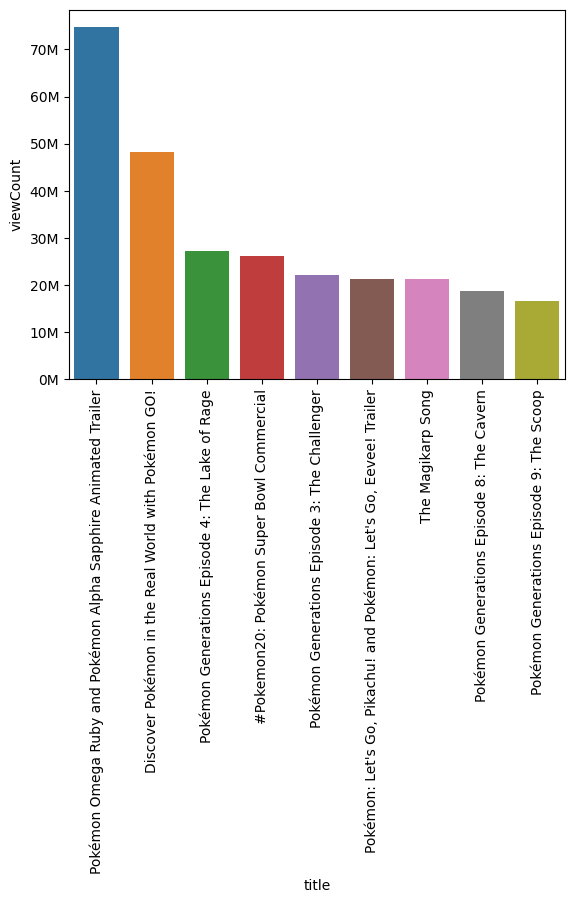

In [99]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000000) + 'M'))

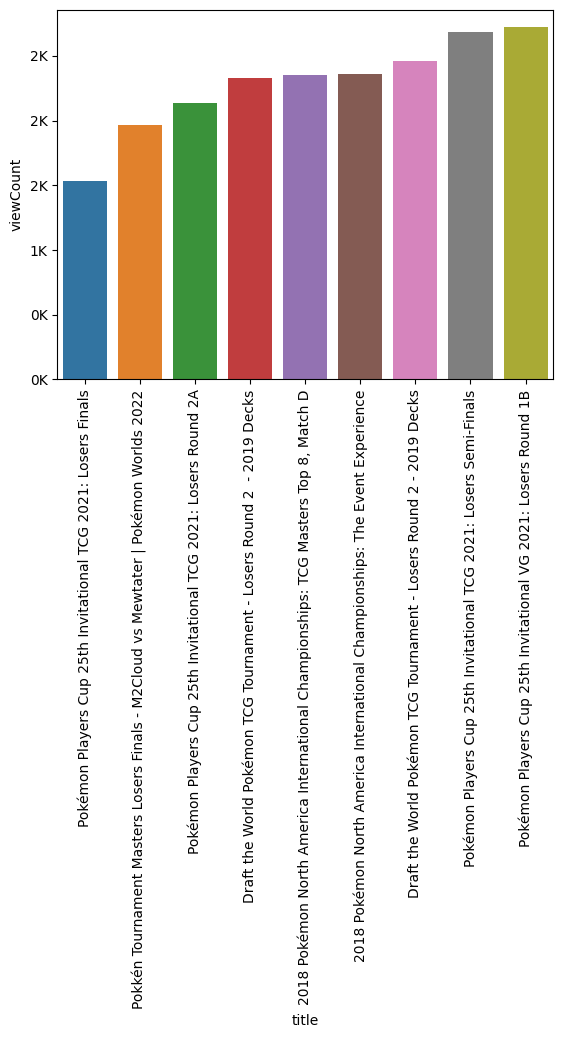

In [100]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

c:\Users\chang\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='channelTitle', ylabel='viewCount'>

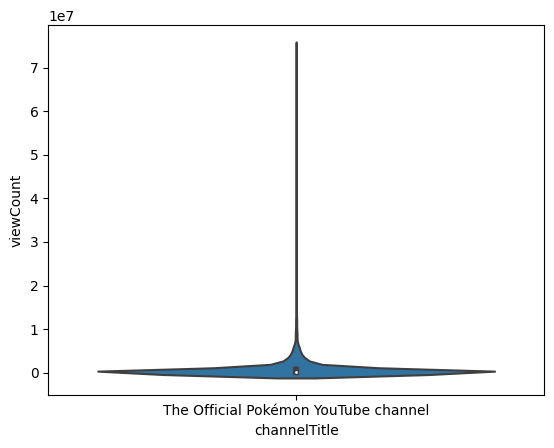

In [101]:
#View distribution per video
sns.violinplot(video_df['channelTitle'], video_df['viewCount'])

<AxesSubplot:xlabel='likeCount', ylabel='viewCount'>

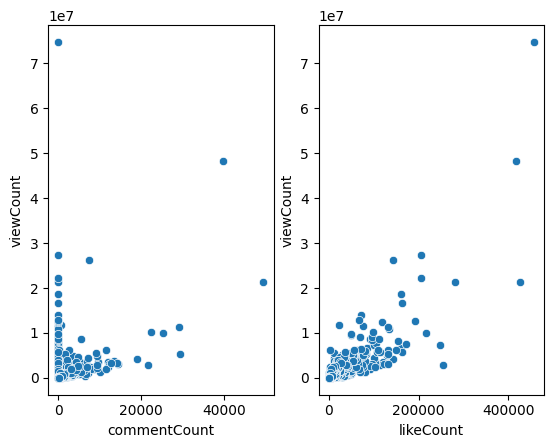

In [102]:
#View compares to likes and comments
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])

<AxesSubplot:xlabel='durationSecs', ylabel='Count'>

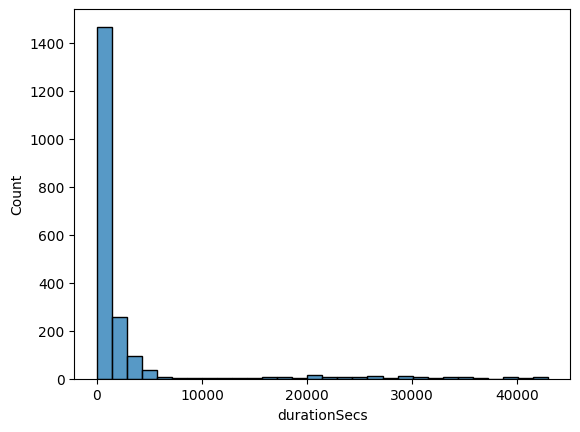

In [103]:
sns.histplot(data = video_df, x = 'durationSecs', bins=30)

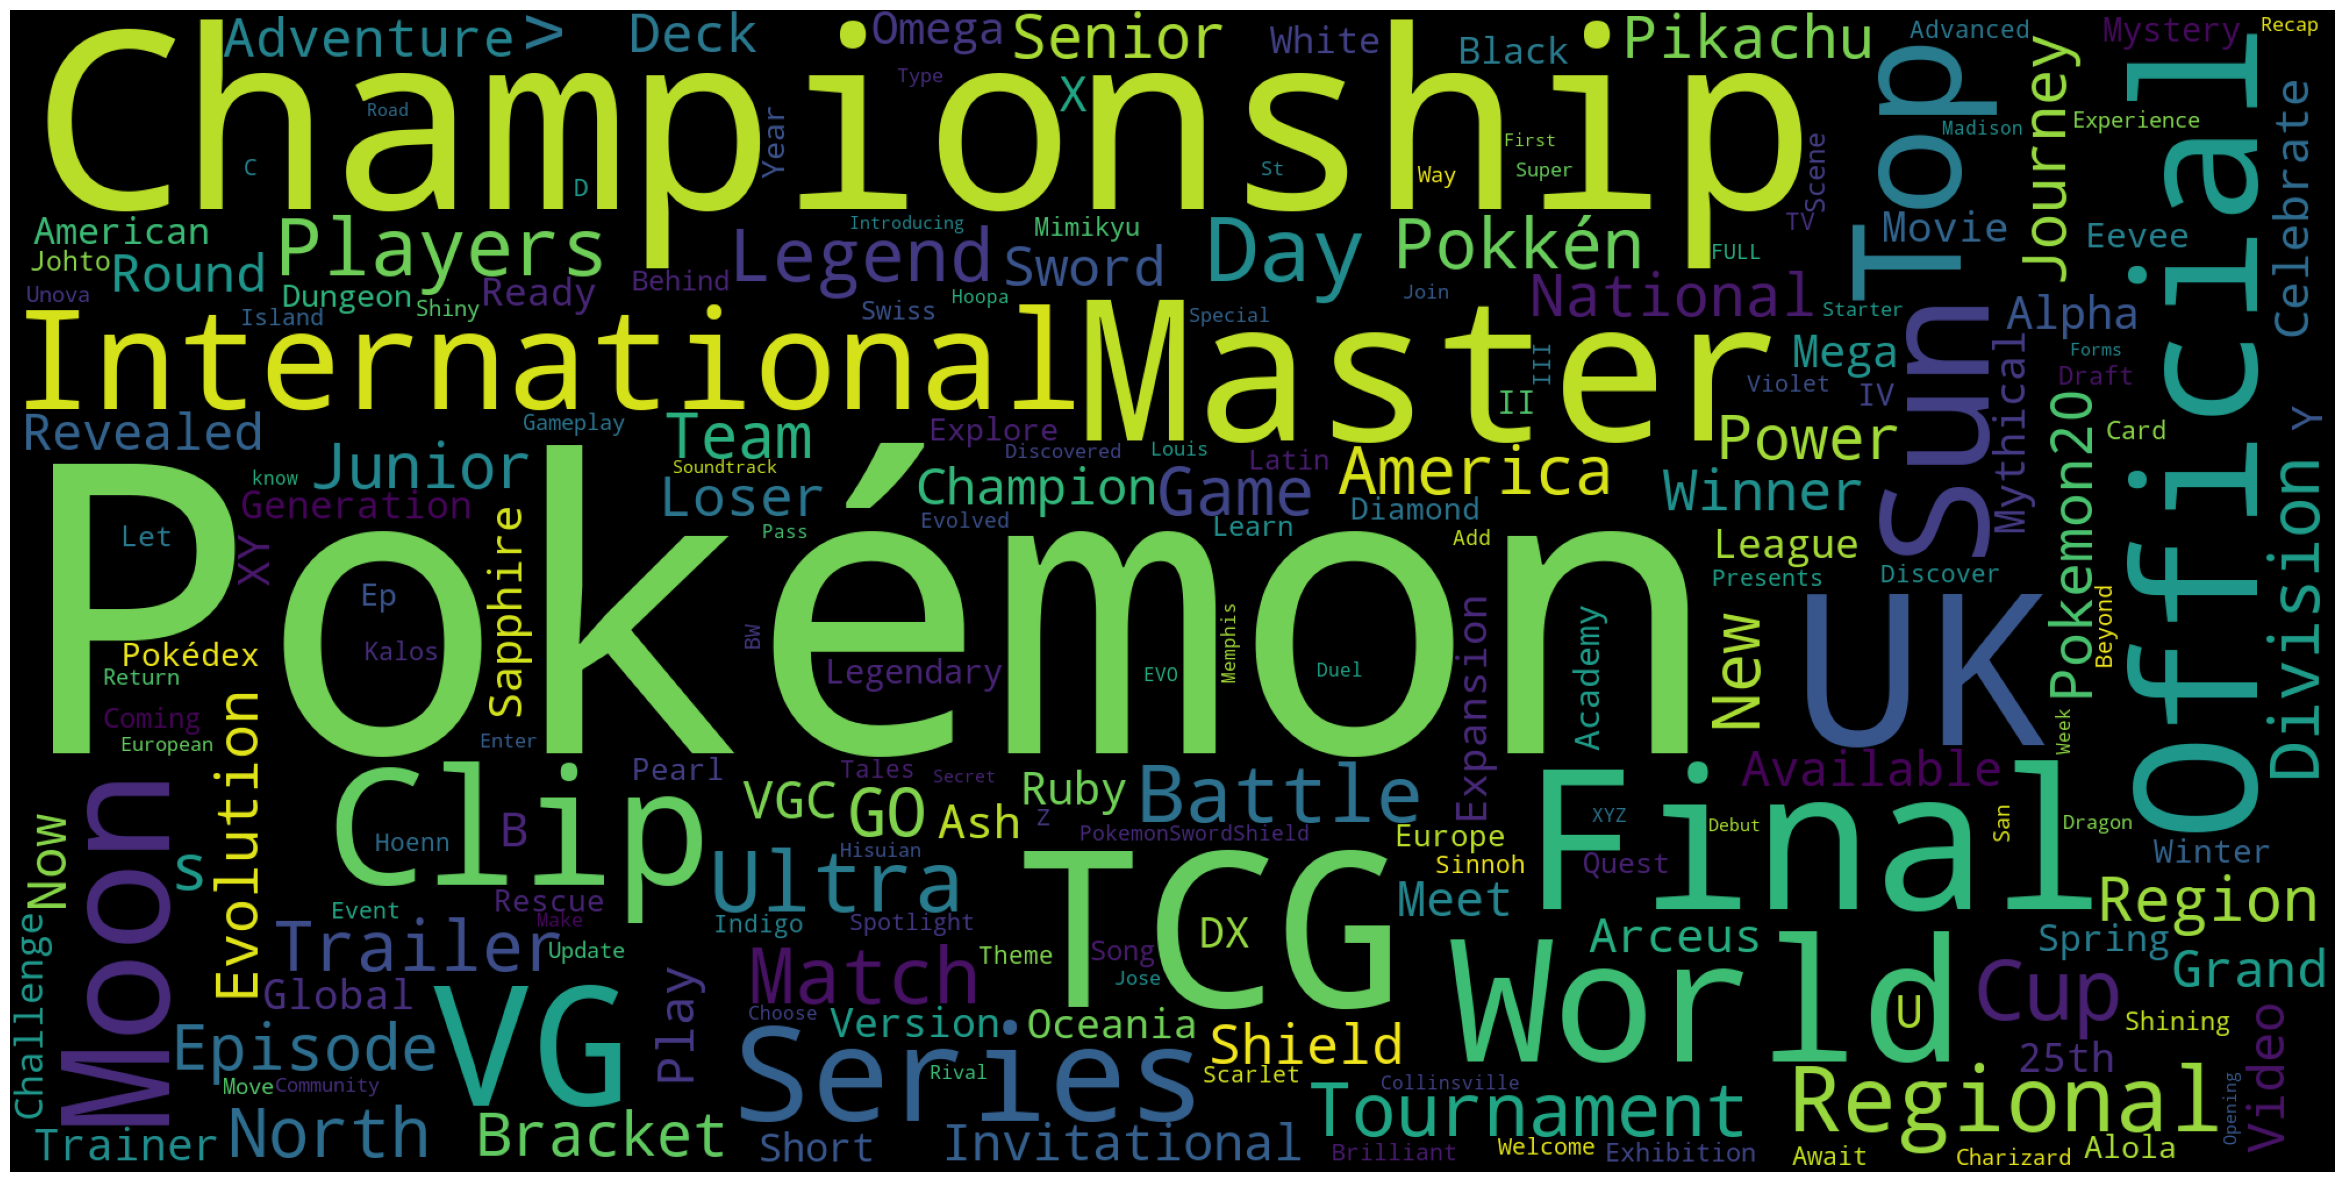

In [104]:
#WORD CLOUD
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

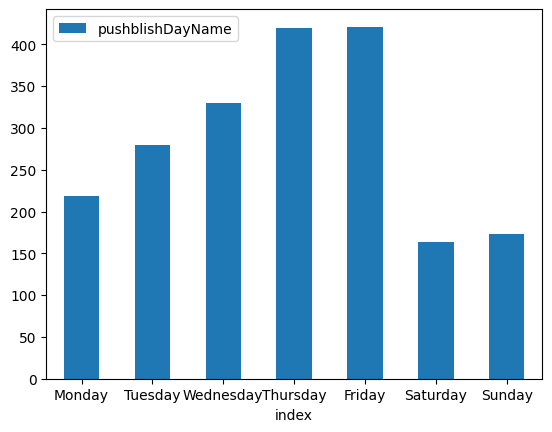

In [105]:
#Schedule
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)